## Quantum Random Walk
This notebook generates a sample of a Bernoulli and a binomial distribution using a quantum
circuit and performs a random walk based on this data

### Setup environment
Let's set up a quantum environment using IBMQ and qiskit

In [42]:
# Imports
from datetime import datetime
import pandas as pd
import qiskit as qml
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt

In [43]:
# Configuration
LOCAL_SIMULATION = False
SHOTS = 8000
BINOMIAL_N = 20
RANDOM_WALK_DAYS = 200
BERNOULLI_PATH = "../output/bernoulli_sample.csv"
BINOMIAL_PATH = "../output/binomial_sample.csv"
RANDOM_WALK_PATH = "../output/random_walk.csv"

In [44]:
# Load IBMQ account
if not qml.IBMQ.active_account():
    qml.IBMQ.load_account()

In [45]:
# Get backend
provider = qml.IBMQ.get_provider(hub='ibm-q')

if LOCAL_SIMULATION:
    backend = qml.Aer.get_backend('aer_simulator')
else:
    backend = least_busy(provider.backends(simulator=False, operational=True))

print("Using Backend:", backend)

Using Backend: ibmq_armonk


### Run quantum circuit
We define and run a simple quantum circuit in order to generate a sample of random data

In [46]:
# Define circuit
circuit = qml.QuantumCircuit(1)
circuit.h(0)
circuit.measure_all()
compiled_circuit = qml.transpile(circuit, backend)

In [47]:
# Run circuit
print("Running circuit:", datetime.now())

result = backend.run(compiled_circuit, memory=True, shots=SHOTS).result()
random_numbers = result.get_memory()

print("Finished:", datetime.now())

Running circuit: 2022-02-01 16:05:19.926156
Finished: 2022-02-01 16:09:02.259010


### Bernoulli distribution
The generated quantum data follows a Bernoulli distribution with $p=0.5$

In [48]:
# Construct data frame
bernoulli_frame = pd.DataFrame({"x": random_numbers})
bernoulli_frame["x"] = bernoulli_frame["x"].astype("int")
print(bernoulli_frame.head())

   x
0  0
1  1
2  1
3  1
4  0


Zero: 4089
One: 3911


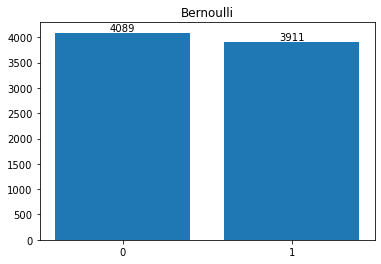

In [49]:
# Evaluate distribution
x = bernoulli_frame["x"]

zero = len(x[x == 0])
one = len(x[x == 1])

print("Zero:", zero)
print("One:", one)

fig, ax = plt.subplots()
plt.title("Bernoulli")
ax.bar(["0", "1"], [zero, one])
ax.bar_label(ax.containers[0])
plt.show()

### Binomial distribution
A simple operation allows us to transform the data into a binomial distribution. There are various ways
to derive different distributions from quantum data

In [50]:
binomial_frame = bernoulli_frame.groupby(
    bernoulli_frame.index // BINOMIAL_N).sum().reset_index(drop=True)
print(binomial_frame.head())

    x
0  10
1  10
2  15
3  10
4   6


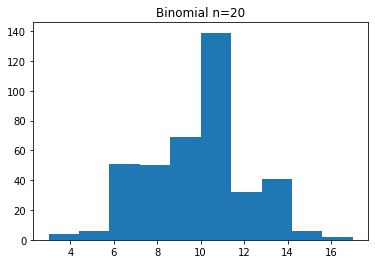

In [51]:
# Evaluate distribution
plt.title("Binomial n=" + str(BINOMIAL_N))
plt.hist(binomial_frame["x"])
plt.show()

### Random walk
We now perform a random walk simulating the price of a stock for 200 days with $p_0=100$

In [52]:
# Perform a bernoulli random walk
total_numbers = len(bernoulli_frame)
simulation_rounds = RANDOM_WALK_DAYS
simulation_runs = total_numbers // simulation_rounds
p = 0.01
q = -0.01
open_price = 100.0

simulation_frame = None

for i in range(simulation_runs):
    start_index = i * simulation_rounds
    end_index = start_index + simulation_rounds

    current_frame = pd.DataFrame({"x": bernoulli_frame["x"][start_index:end_index]})
    current_frame["r"] = current_frame["x"]
    current_frame.loc[current_frame["r"] == 1, "r"] = 1 + p
    current_frame.loc[current_frame["r"] == 0, "r"] = 1 + q
    current_frame["r"] = current_frame["r"].cumprod()
    current_frame["price"] = open_price * current_frame["r"]
    current_frame["stock"] = i
    current_frame["day"] = range(1, simulation_rounds + 1)

    if start_index == 0:
        simulation_frame = current_frame
    else:
        simulation_frame = simulation_frame.append(current_frame, ignore_index=True)

    simulation_frame.reset_index(drop=True)

### Analyse results

The random walks show the volatility of the final stock price, $p_n$, after 200 days. We can use
this variance to measure risk and to price derivatives, for example European options

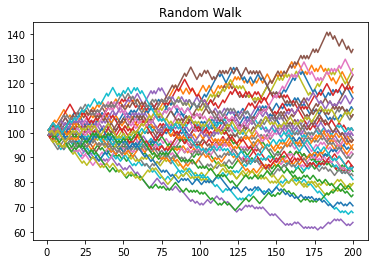

In [53]:
# Plot series
plt.figure()
plt.title("Random Walk")

for i in range(simulation_runs):
    stock_frame = simulation_frame[simulation_frame["stock"] == i]
    plt.plot(stock_frame["day"], stock_frame["price"], "-")

plt.show()

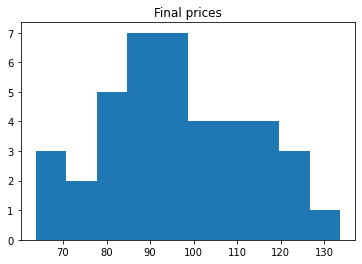

In [54]:
# Plot price distribution
final_frame = simulation_frame[simulation_frame["day"] == RANDOM_WALK_DAYS]
plt.title("Final prices")
plt.hist(final_frame["price"])

plt.show()

In [55]:
# Print statistics
print("Runs:", simulation_runs)
print("Days per run:", simulation_rounds)
print("High price:", final_frame["price"].max())
print("Low price:", final_frame["price"].min())

Runs: 40
Days per run: 200
High price: 133.64401849042852
Low price: 63.7618480419076


### Store results
Let's store the results for further analysis

In [56]:
bernoulli_frame.to_csv(BERNOULLI_PATH, index=False)
binomial_frame.to_csv(BINOMIAL_PATH, index=False)
simulation_frame.to_csv(RANDOM_WALK_PATH, index=False)